 # Assignment 2 - Modern CNNs (ResNet)
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Dr. Risman Adnan.*

This is part 6/7 of this week's assignment. In this notebook, I will attempt to implement ResNet.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import torch.nn.functional as F

In [2]:
cuda = torch.device('cuda')

## Importing Dataset

I will use the MNIST dataset to train and test the model in this notebook. Because MNIST contains images of shape 28x28 pixels and because ResNet accepts images of size 244x244 pixels, I will upscale each image in the dataset to 244x244 pixels.

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(224)]) # Upscale to 244x224 pixels
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(
                 dataset=training_data,
                 batch_size=256,
                 shuffle=True,
                 num_workers=2,
                 pin_memory=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_data,
                batch_size=256,
                shuffle=False,
                num_workers=2,
                pin_memory=True)

Below are nine samples of the dataset

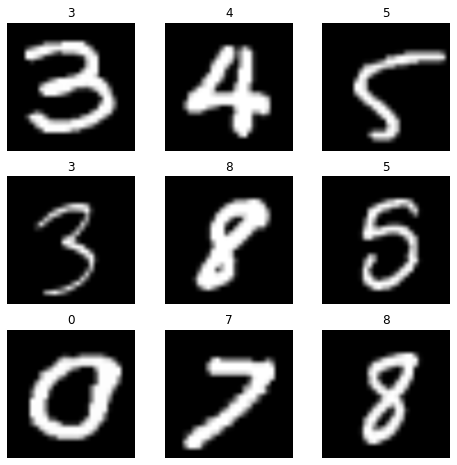

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Definining Helper Functions

The function below will be used to train the neural network

In [6]:
def train(net, train_loader, epochs=10, lr=0.001): 

    optimizer = optim.Adam(net.parameters())
    criterion = nn.CrossEntropyLoss()

    net.to(cuda)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        net.train()
        for X, y in train_loader:
            X, y = X.to(cuda), y.to(cuda)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f'Epoch: {epoch + 1}, loss: {running_loss / len(train_loader.dataset):.6f}')

    print('Finished Training')
    total, correct = test(net, train_loader)
    print(f'Train accuracy: {(correct/total)*100}%')

The function below will be used to calculate the neural network's test accuracy.

In [7]:
def test(net, test_loader):
    
    total = 0
    correct = 0

    for X, y in test_loader:
        net.eval()
        X, y = X.to(cuda), y.to(cuda)

        y_hat = net(X).argmax(axis=1)
        total += X.shape[0]
        correct += (y_hat == y).sum()

    return total, correct
  

## ResNet

ResNet is comprised of residual blocks. These blocks learn the residual mapping $f(x)-x$ and can forward propagate the inputs through residual connections.

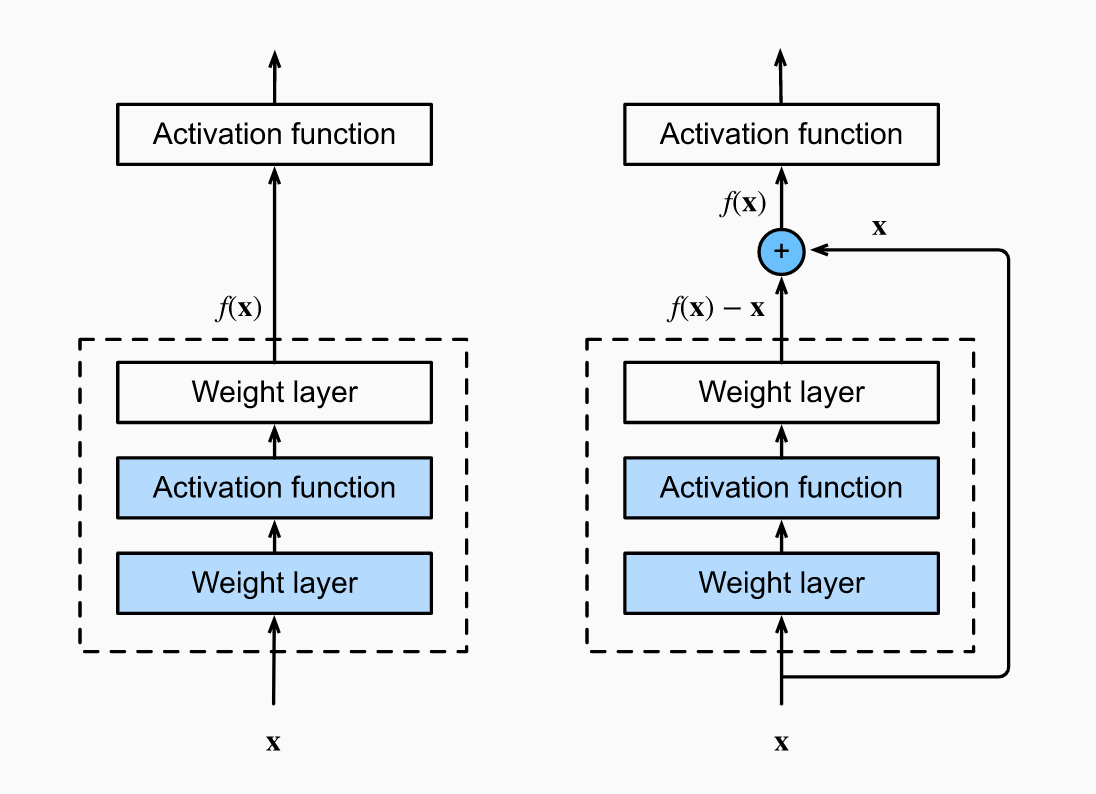

The residual blocks are similar to a VGG block, which contain a sequence of 3x3 convolutional layers. However, it differs in the fact that there are only two convolutional blocks, where each convolutional layer is followed by a batch normalization and a ReLU activation function. In addition to this, the input also skips these convolutional layers and is directly added with the output of convolutional layers, before the final ReLU function. This design requires that the output of the two convolutional layers be the same shape as the input. If the number of channels would like to be changed, then a 1x1 convolutional layer is applied to the input to transform it to the desired shape. 

Below is an implementation of the explained residual block

In [8]:
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

**ResNet Model**

The first two layers of ResNet are similar as GoogLeNet, in which there is a 7x7 convolutional layer with 64 output channels with a stride of 2, followed by 3x3 maximum pooling layer with stride of 2. The difference is that batch normalization is added after each convolutional layer

In [9]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

Resnet uses four modules made up of residual blocks, each with the same number of output channels. The number of output channels in the first module is the same as the number of input channels. The subsequent modules double the output channels of the previous layer.

Below is an implementation of a resnet module

In [10]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Below are the creation of the four resnet modules, as explained above.

In [11]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

The final two layers are a a global average pooling layer followed by a fully connect layer with output channels equalling the number of label classes.

In [12]:
resnet = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

I will train ResNet with a learning rate of 0.05 and a total of 10 epochs.

In [13]:
train(resnet, train_loader, lr=0.05, epochs=10) 

Epoch: 1, loss: 0.000639
Epoch: 2, loss: 0.000150
Epoch: 3, loss: 0.000114
Epoch: 4, loss: 0.000088
Epoch: 5, loss: 0.000076
Epoch: 6, loss: 0.000059
Epoch: 7, loss: 0.000046
Epoch: 8, loss: 0.000052
Epoch: 9, loss: 0.000041
Epoch: 10, loss: 0.000041
Finished Training
Train accuracy: 99.42166900634766%


In [14]:
total, correct = test(resnet, test_loader)  

In [15]:
print(f"Test Accuracy: {(correct/total)*100}% ({correct}/{total})")

Test Accuracy: 98.97999572753906% (9898/10000)


As you can see, the trained ResNet model has a test accuracy of 98.98%. 

## Visualizing Predictions


Below are five visual representations of ResNet's predictions.

In [16]:
def viz_results(net, dataset, num_samples=5):
    net.cpu()
    for i, (x, y) in enumerate(iter(dataset), 1):
        if i <= num_samples:
            
            x, y = x, y
            x = x.reshape(1, 1, x.shape[1], x.shape[2])

            y_hat = net(x).argmax()

            plt.imshow(x.reshape(x.shape[1], x.shape[2], -1).squeeze())
            plt.title(f'{i}. Actual: {y}; Predicted: {y_hat}')
            plt.show()
        else:
            break

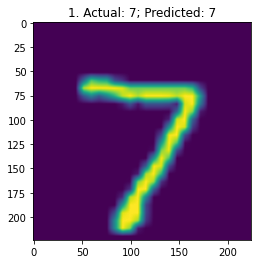

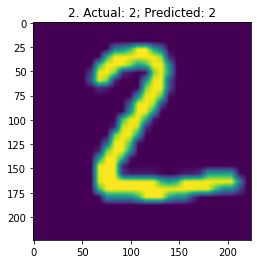

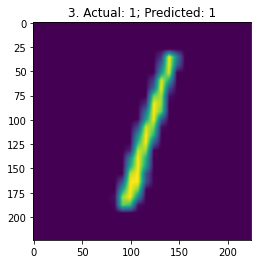

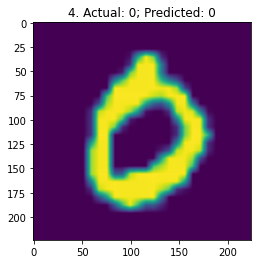

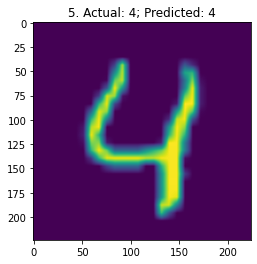

In [17]:
viz_results(resnet, test_data)